# <center> Classification des styles artistiques 

### 1. Préparation des données

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

import src.ml_utils as ml

from importlib import reload
reload(ml);

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.svm import SVC

In [2]:
#On transforme en dataframe le CSV de la partie vision
df_vision = pd.read_csv("../results/CSV/dataset_vision_features.csv")

### 2. Entrainement du SVM 

On va d'abord trouver le meilleur SVM pour notre dernier CSV fréquence qui contient 19 caractéristiques

In [3]:
X_combined, y_combined, fold, X_test_s, y_test = ml.preparer_donnees_combinees(
    df_vision, 
    "../results/CSV/final_frequency_features_minimal.csv" #CSV avec 19 caractéristiques 
)

# Création de l'objet de split pour le GridSearchCV
ps = PredefinedSplit(test_fold=fold)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.001],
    'kernel': ['rbf']
}

print("Lancement du GridSearchCV pour le fichier csv avec 19 caractéristiques fréquentielles...")
grid = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=ps, verbose=2, n_jobs=-1)

grid.fit(X_combined, y_combined)

print("-" * 30)
print(f"Meilleurs paramètres : {grid.best_params_}")
print(f"Meilleur score en Validation : {grid.best_score_:.2%}")
test_score = grid.score(X_test_s, y_test)
print(f"Score final sur le TEST : {test_score:.2%}")

Lancement du GridSearchCV pour le fichier csv avec 19 caractéristiques fréquentielles...
Fitting 1 folds for each of 16 candidates, totalling 16 fits
------------------------------
Meilleurs paramètres : {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Meilleur score en Validation : 28.91%
Score final sur le TEST : 29.03%


In [4]:
X_combined, y_combined, fold, X_test_s, y_test = ml.preparer_donnees_combinees(
    df_vision, 
    "../results/CSV/final_frequency_features.csv" #CSV avec 47 caractéristiques 
)

# Création de l'objet de split pour le GridSearchCV
ps = PredefinedSplit(test_fold=fold)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.001],
    'kernel': ['rbf']
}

print("Lancement du GridSearchCV pour le fichier csv avec 47 caractéristiques fréquentielles...")
grid = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=ps, verbose=2, n_jobs=-1)

grid.fit(X_combined, y_combined)

print("-" * 30)
print(f"Meilleurs paramètres : {grid.best_params_}")
print(f"Meilleur score en Validation : {grid.best_score_:.2%}")
test_score = grid.score(X_test_s, y_test)
print(f"Score final sur le TEST : {test_score:.2%}")

Lancement du GridSearchCV pour le fichier csv avec 47 caractéristiques fréquentielles...
Fitting 1 folds for each of 16 candidates, totalling 16 fits
------------------------------
Meilleurs paramètres : {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Meilleur score en Validation : 30.30%
Score final sur le TEST : 31.42%


Les meilleurs performances se font avec le dataset avec les 47 caractéristiques fréquentielles et les caractéristiques issues de la vision.   
Affichons ses résultats :

 Résultats pour le SVM sur les caractéristiques vision et fréquence
Précision Globale (Accuracy) : 31.42%
F1-Score Global (Weighted)   : 31.10%

--- Rapport de Performance détaillé ---
                            precision    recall  f1-score   support

    Abstract_Expressionism       0.20      0.27      0.23        49
               Art_Nouveau       0.14      0.15      0.14        55
                   Baroque       0.31      0.37      0.34        60
      Color_Field_Painting       0.48      0.53      0.50        51
      Contemporary_Realism       0.27      0.28      0.27        57
                    Cubism       0.28      0.28      0.28        60
         Early_Renaissance       0.43      0.41      0.42        70
             Expressionism       0.09      0.10      0.10        58
                   Fauvism       0.20      0.29      0.24        55
          High_Renaissance       0.36      0.45      0.40        58
             Impressionism       0.24      0.26      0.25        6

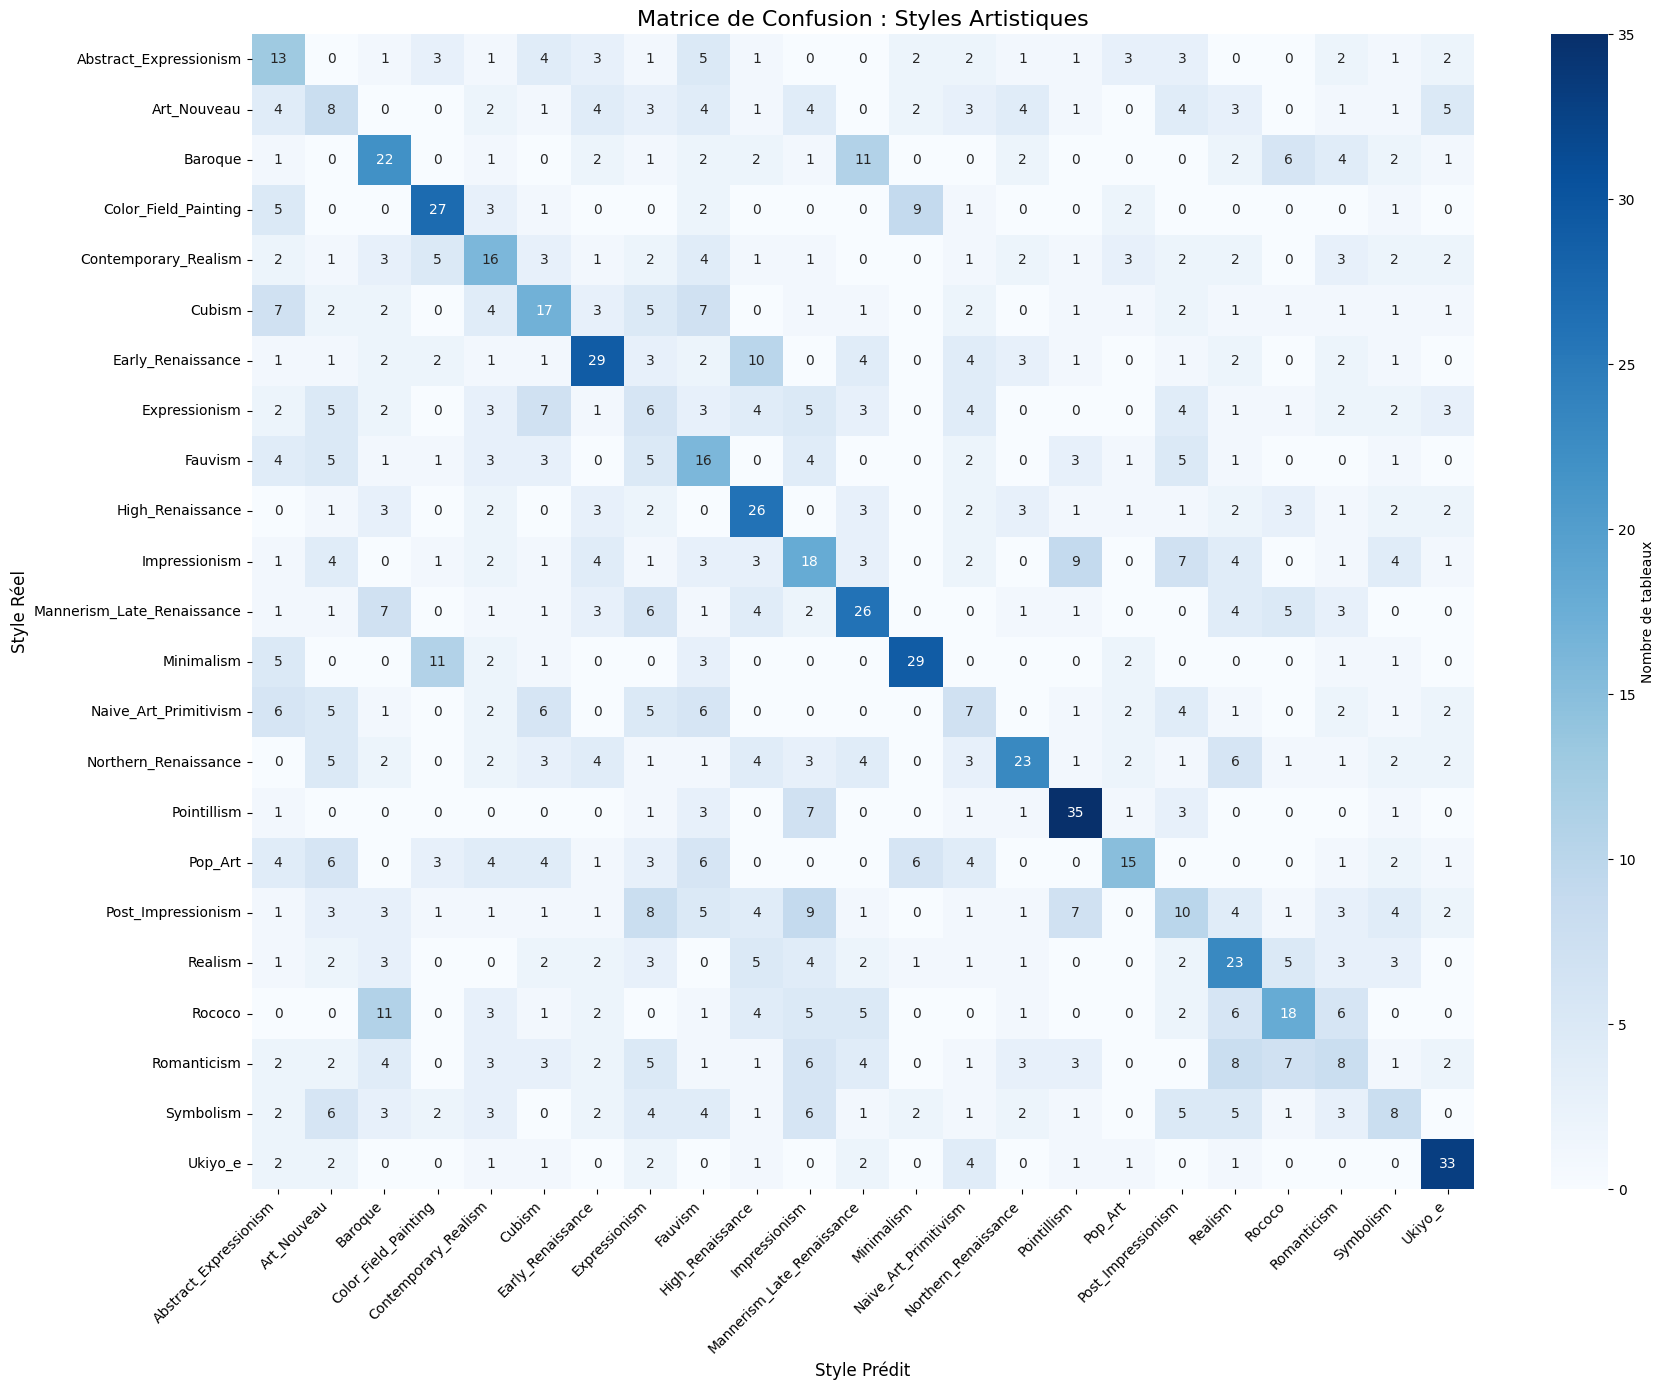

In [5]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

y_pred = grid.predict(X_test_s) 

# Calcul des métriques globales
acc = accuracy_score(y_test, y_pred)
f1_glob = f1_score(y_test, y_pred, average='weighted')

print(f" Résultats pour le SVM sur les caractéristiques vision et fréquence")

print(f"Précision Globale (Accuracy) : {acc:.2%}")
print(f"F1-Score Global (Weighted)   : {f1_glob:.2%}")

# Analyse détaillée par style
print("\n--- Rapport de Performance détaillé ---")
print(classification_report(y_test, y_pred))

# Analyse visuelle
import src.ml_utils as ml
ml.plot_art_confusion_matrix(y_test, y_pred)

### 3. Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier

# Chargement et préparation des données (sur csv minimal avec 19 caractéristiques fréquentielles)
X_combined, y_combined, fold, X_test_s, y_test = ml.preparer_donnees_combinees(
    df_vision, 
    "../results/CSV/final_frequency_features_minimal.csv"
)

# Pour le Random Forest sans GridSearchCV, on utilise X_combined (Train + Val) pour l'entraînement
# Note : On utilise les données standardisées même si RF n'est pas sensible à l'échelle

rf_minimal = RandomForestClassifier(n_estimators=500, 
                                    class_weight='balanced', 
                                    random_state=42,
                                    n_jobs=-1)

rf_minimal.fit(X_combined, y_combined)

# Prédictions et Métriques
y_pred_rf_min = rf_minimal.predict(X_test_s)

print("Résultats pour le Random Forest sur les caractéristiques vision et fréquence (19 features fréquence)")
print(f"Précision Globale : {accuracy_score(y_test, y_pred_rf_min):.2%}")
print(f"F1-Score (Weighted) : {f1_score(y_test, y_pred_rf_min, average='weighted'):.2%}")
print("\n Rapport détaillé")
print(classification_report(y_test, y_pred_rf_min))


Résultats pour le Random Forest sur les caractéristiques vision et fréquence (19 features fréquence)
Précision Globale : 30.26%
F1-Score (Weighted) : 27.86%

 Rapport détaillé
                            precision    recall  f1-score   support

    Abstract_Expressionism       0.28      0.14      0.19        49
               Art_Nouveau       0.20      0.13      0.16        55
                   Baroque       0.23      0.25      0.24        60
      Color_Field_Painting       0.46      0.63      0.53        51
      Contemporary_Realism       0.37      0.12      0.18        57
                    Cubism       0.22      0.17      0.19        60
         Early_Renaissance       0.30      0.44      0.36        70
             Expressionism       0.17      0.07      0.10        58
                   Fauvism       0.15      0.38      0.22        55
          High_Renaissance       0.29      0.21      0.24        58
             Impressionism       0.21      0.20      0.21        69
Manneri

In [7]:
from sklearn.ensemble import RandomForestClassifier

# Chargement et préparation des données (sur csv contenant les 47 caractéristiques fréquentielles)
X_combined, y_combined, fold, X_test_s, y_test = ml.preparer_donnees_combinees(
    df_vision, 
    "../results/CSV/final_frequency_features.csv"
)

# Pour le Random Forest sans GridSearchCV, on utilise X_combined (Train + Val) pour l'entraînement
rf_47_features = RandomForestClassifier(n_estimators=500, 
                                    class_weight='balanced', 
                                    random_state=42,
                                    n_jobs=-1)

rf_47_features.fit(X_combined, y_combined)

# Prédictions et Métriques
y_pred_rf = rf_47_features.predict(X_test_s)

print("Résultats pour le Random Forest sur les caractéristiques vision et fréquence (47 features fréquence)")
print(f"Précision Globale : {accuracy_score(y_test, y_pred_rf):.2%}")
print(f"F1-Score (Weighted) : {f1_score(y_test, y_pred_rf, average='weighted'):.2%}")
print("\n Rapport détaillé")
print(classification_report(y_test, y_pred_rf))

Résultats pour le Random Forest sur les caractéristiques vision et fréquence (47 features fréquence)
Précision Globale : 30.77%
F1-Score (Weighted) : 28.11%

 Rapport détaillé
                            precision    recall  f1-score   support

    Abstract_Expressionism       0.18      0.08      0.11        49
               Art_Nouveau       0.17      0.07      0.10        55
                   Baroque       0.26      0.28      0.27        60
      Color_Field_Painting       0.44      0.61      0.51        51
      Contemporary_Realism       0.30      0.16      0.21        57
                    Cubism       0.23      0.15      0.18        60
         Early_Renaissance       0.31      0.44      0.36        70
             Expressionism       0.24      0.09      0.13        58
                   Fauvism       0.17      0.42      0.24        55
          High_Renaissance       0.24      0.16      0.19        58
             Impressionism       0.22      0.20      0.21        69
Manneri

Le dataset comprenant les 47 caractéristiques fréquentielles semblent permettre d'obtenir de meilleurs résultats 

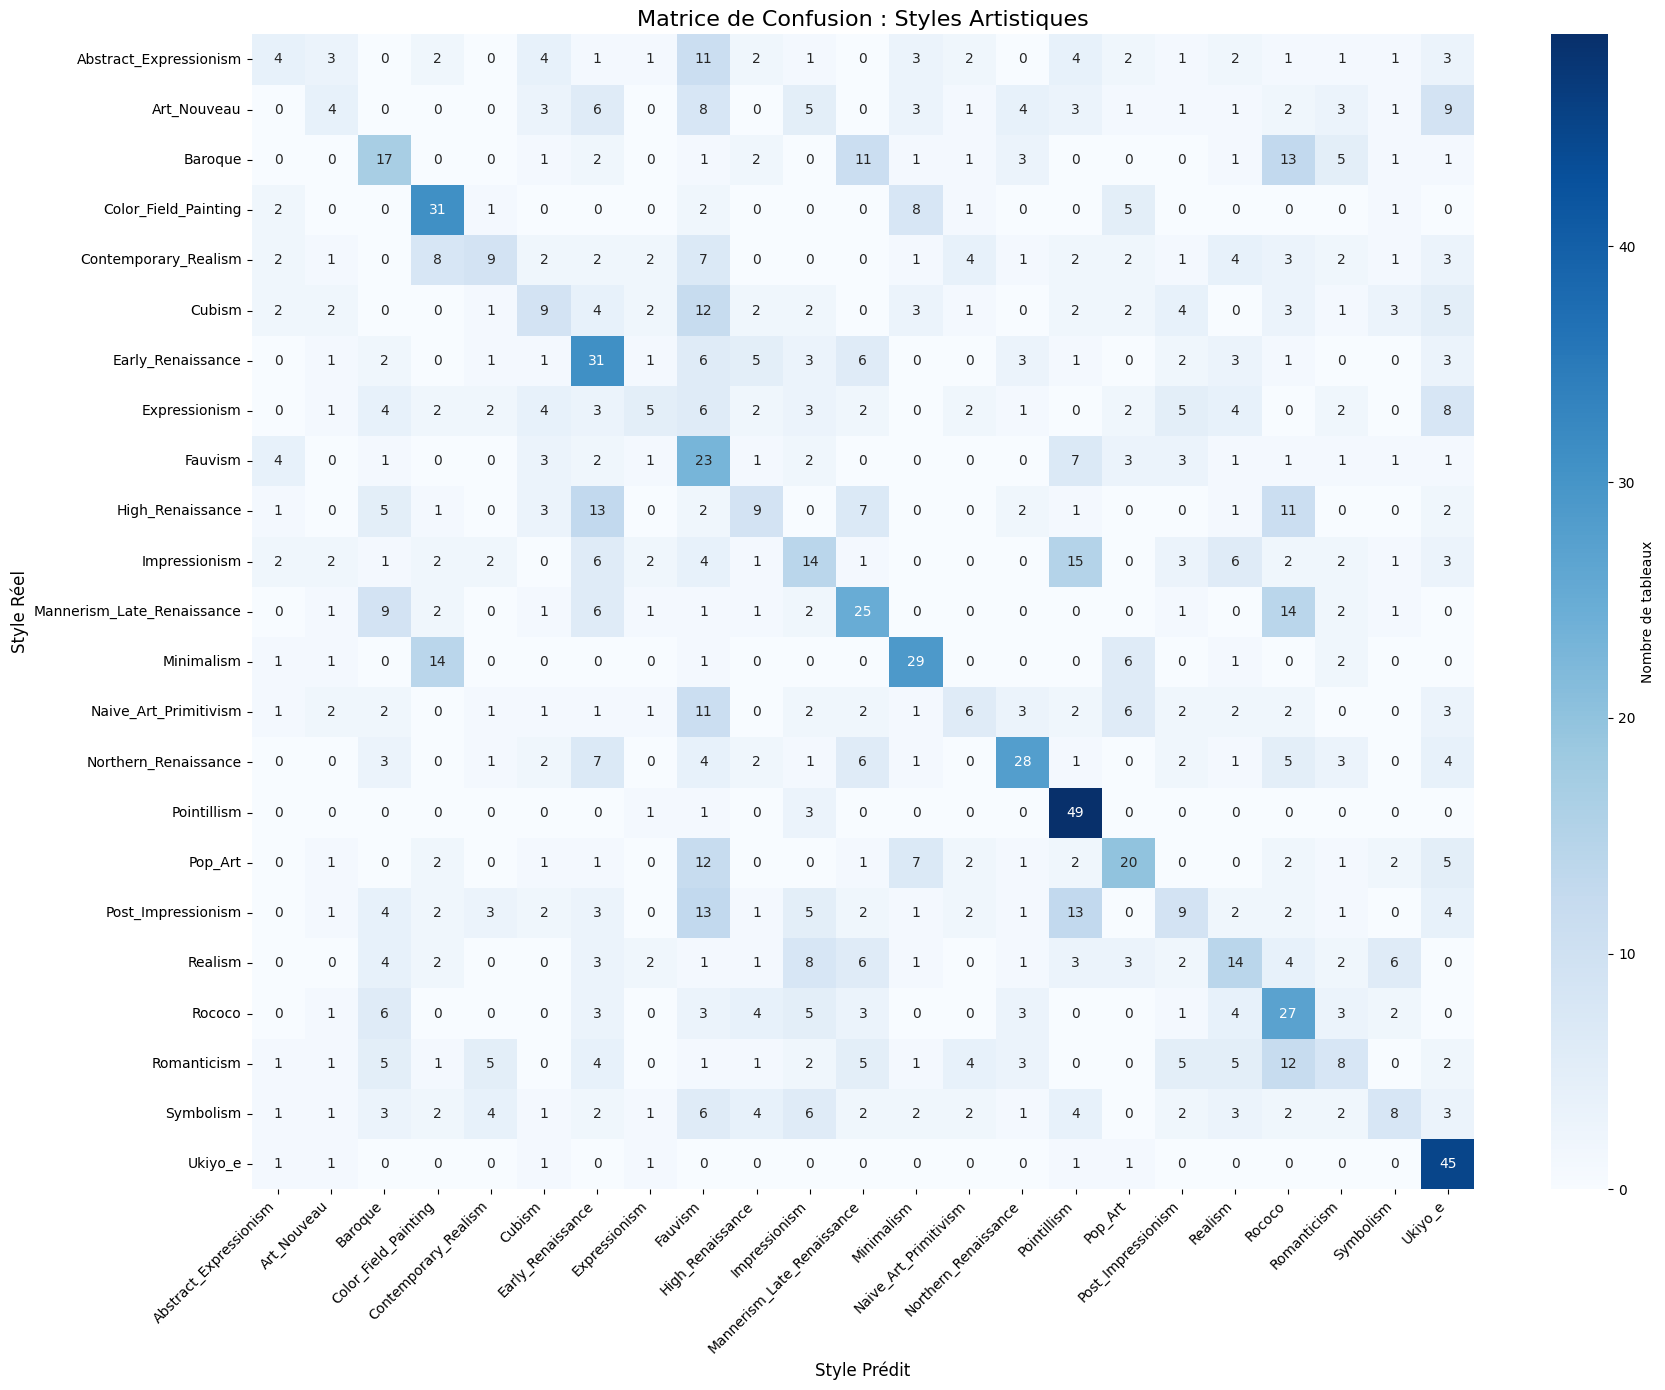

In [8]:
# Analyse visuelle
import src.ml_utils as ml
ml.plot_art_confusion_matrix(y_test, y_pred_rf)

In [9]:
# On récupére les noms des colonnes
df_freq_temp = pd.read_csv("../results/CSV/final_frequency_features.csv")
df_merged = pd.merge(df_vision, df_freq_temp, on=["filename", "split", "style_name"])

feature_names = df_merged.drop(columns=['filename', 'split', 'style_name']).columns.tolist()

# On lie les noms aux importances du Random Forest
importances = rf_47_features.feature_importances_
df_imp = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)

print("Top 10 des caractéristiques les plus discriminantes (Global) :")
print(df_imp.head(10))

Top 10 des caractéristiques les plus discriminantes (Global) :
                    feature  importance
227                lab_pc_2    0.006859
340  gabor_entropy_th135_f1    0.006691
303        spectral_entropy    0.006523
321       gabor_var_th45_f1    0.006485
339      gabor_var_th135_f1    0.006318
322   gabor_entropy_th45_f1    0.006255
302        energy_periphery    0.006221
225                lab_pc_0    0.006001
343  gabor_entropy_th135_f2    0.005927
325   gabor_entropy_th45_f2    0.005855


On voit que le modèle s'appuie beaucoup sur :
- la texture (gabor_entropy_th135_f1, gabor_var_th45_f1, gabor_var_th135_f1, gabor_entropy_th45_f1, gabor_entropy_th135_f2, gabor_entropy_th45_f2) notamment aux angles 45° et 135°. La directionnalité des coup de pinceau est donc un facteur clé.  
- la couleur (lab_pc_2, lab_pc_0), la palette chromatique semble donc discriminante.  
- la fréquence/structure (spectral_entropy, energy_periphery) est également importante. Spectral entropy capture le niveau de 'fouillis' visuel et energy_periphery capture la composition. 

Analyse critique des familles
                          sum     mean  count
famille                                      
Structure (HOG)        39.70%  0.2647%    150
Couleur (LAB)          21.63%  0.2885%     75
Couleur (HSV)          20.51%  0.2734%     75
Texture (Gabor)        14.29%  0.3969%     36
Fréquentiel (Fourier)   3.87%  0.4839%      8


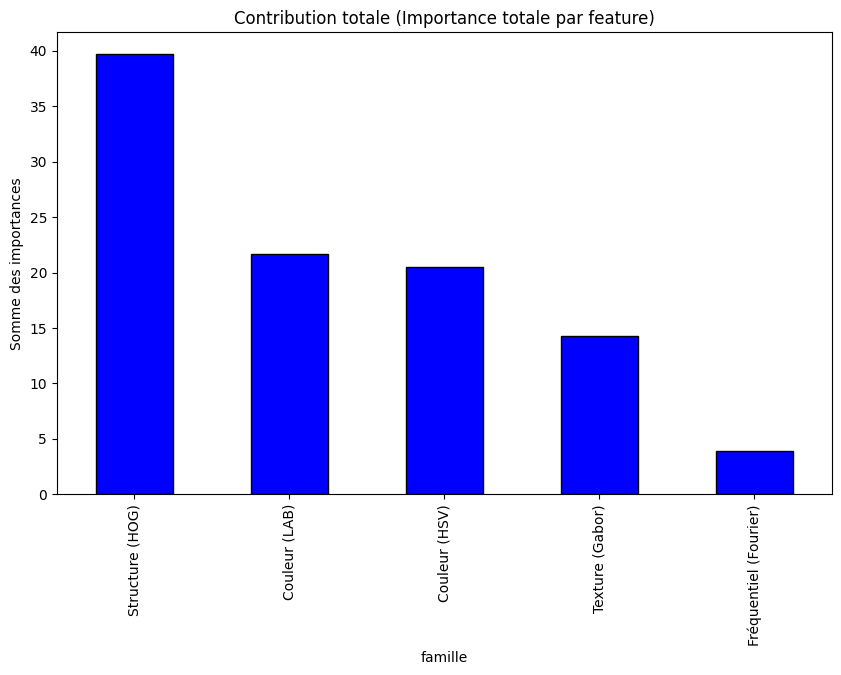

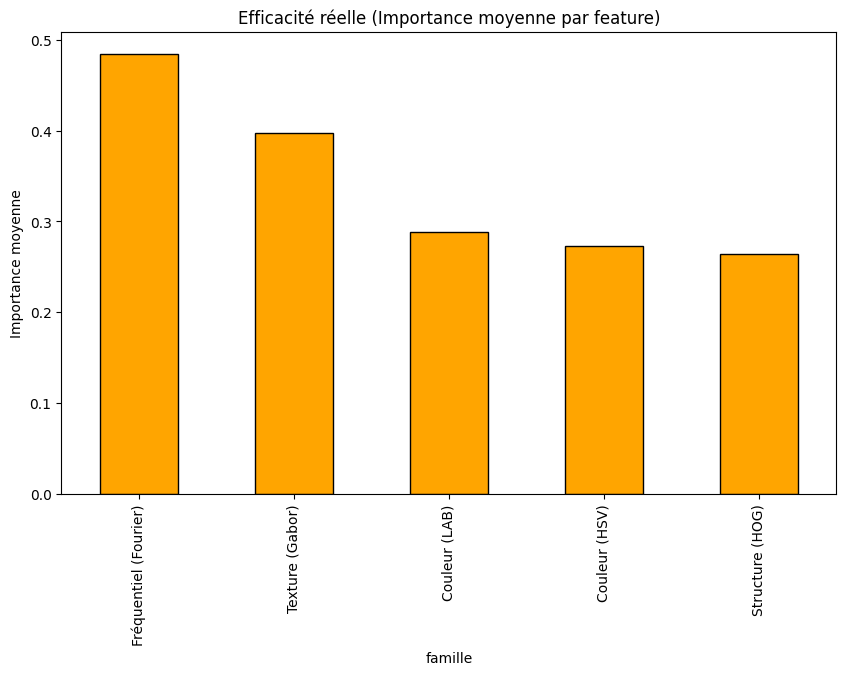

In [10]:
from matplotlib import pyplot as plt

stats_importance = ml.analyser_importance_familles(rf_47_features, feature_names)

print("Analyse critique des familles")
# Affichage formaté
display_df = stats_importance.copy()
display_df['sum'] = display_df['sum'].map(lambda x: f"{x:.2%}")
display_df['mean'] = display_df['mean'].map(lambda x: f"{x:.4%}")
print(display_df)

# Visualisation de la somme
plt.figure(figsize=(10, 6))
(stats_importance['sum']*100).sort_values(ascending=False).plot(kind='bar', color='blue', edgecolor='black')
plt.title('Contribution totale (Importance totale par feature)')
plt.ylabel('Somme des importances')
plt.show()

# Visualisation de la moyenne (L'efficacité réelle)
plt.figure(figsize=(10, 6))
(stats_importance['mean']*100).sort_values(ascending=False).plot(kind='bar', color='orange', edgecolor='black')
plt.title('Efficacité réelle (Importance moyenne par feature)')
plt.ylabel('Importance moyenne')
plt.show()

On voit que les structures HOG et couleurs (HSV et LAB) dominent l'importance totale mais cela est fortement corrélé au nombre élevé de descripteurs utilisés.    

On observe sur le deuxième plot l'importance moyenne par caractéristique au sein de chaque famille. On observe que les descripteurs fréquentiels et de texture possèdent des poids élevés. Cela confirme l'intuition de Barina [1] : l'analyse fréquentielle est un signal très dense en information pour l'art.

### 4. Extraction des signatures des styles 

In [11]:
# Chargement et préparation des données (Train + Val)
X_combined, y_combined, fold, X_test_s, y_test = ml.preparer_donnees_combinees(
    df_vision, 
    "../results/CSV/final_frequency_features.csv"
)

# Récupération des noms de colonnes (features)
drop_cols = ['filename', 'split', 'style_name']
feature_names = [c for c in df_vision.columns if c not in drop_cols] + \
                [c for c in pd.read_csv("../results/CSV/final_frequency_features.csv").columns if c not in drop_cols]

# Calcul des signatures moyennes par style
signatures = ml.extraire_signatures_styles(X_combined, y_combined, feature_names)

# Génération du tableau final pédagogique
df_final = ml.generer_tableau_synthese_evolue(signatures)

# Affichage
print("Synthèse des signatures stylistiques")
display(df_final)


Synthèse des signatures stylistiques


,Trait,Contour,Palette,Structure,Signature
Style,,,,,
Abstract Expressionism,Lissé (-0.19),Fondu (-0.00),Riche (0.13),Centrée (+0.11),HSV (Impact 0.62)
Art Nouveau,Équilibré (+0.05),Fondu (-0.00),Sobre (0.05),Diffuse (-0.01),GABOR (+0.51)
Baroque,Lissé (-0.19),Fondu (-0.00),Sobre (0.09),Centrée (+0.12),GABOR (-0.87)
Color Field Painting,Lissé (-0.55),Précis (+0.03),Riche (0.12),Diffuse (-0.09),SPECTRAL (-1.71)
Contemporary Realism,Équilibré (-0.13),Fondu (-0.00),Sobre (0.08),Diffuse (-0.07),HOG (Impact 0.57)
Cubism,Lissé (-0.13),Fondu (-0.01),Sobre (0.09),Centrée (+0.54),ENERGY (+0.64)
Early Renaissance,Vibrant (+0.19),Précis (+0.01),Riche (0.10),Diffuse (+0.09),LAB (Impact 0.53)
Expressionism,Équilibré (-0.03),Fondu (-0.00),Sobre (0.05),Diffuse (+0.09),HOG (Impact 0.23)
Fauvism,Équilibré (+0.11),Fondu (+0.00),Riche (0.13),Centrée (+0.41),LAB (Impact 1.36)


#### Méthodologie

Pour générer le tableau de synthèse, nous avons appliqué la méthode suivante :

**Extraction des Signatures :** Calcul de la moyenne de chaque descripteur (standardisé) pour les 23 styles du dataset.

**Seuillage Dynamique :** Au lieu de seuils arbitraires, nous utilisons les quantiles. Un style est qualifié de "Vibrant" ou "Lissé" seulement s'il se situe dans les extrêmes (top 25%) par rapport à l'ensemble du corpus.

**Agrégation par Axes :**
- Le Trait : Basé sur l'entropie de Gabor (vibration de la touche).
- Le Contour : Basé sur les descripteurs HOG (rigueur du dessin).
- La Palette : Basée sur l'écart à la moyenne des composantes LAB/HSV.
- La Structure : Basée sur le ratio d'énergie Centre/Périphérie.

#### Ce que l'on peut tirer du tableau

Nous pouvons diviser les résultats en trois catégories pour mieux comprendre la performance du modèle :

**Les identités fortes** : Ce sont les styles que le modèle repère presque à coup sûr grâce à des critères extrêmes.

Pointillisme & Impressionnisme : Identifiés par leur vibration (Gabor élevé).

Minimalisme & Color Field : Identifiés par leur vide absolu (Spectral très bas).

Fauvisme : Identifié par ses contrastes de couleurs radicaux (Impact LAB élevé).

**Les structures marqués** :
Ici, c'est l'organisation de la toile qui prime.  

Ukiyo-e : Se distingue par son énergie décentrée (Périphérie).

Cubisme : Se distingue par une concentration massive d'énergie et de formes au centre de la composition.

**Les styles subtils** :
C'est ici que le modèle travaille le plus. Des styles comme la Renaissance, le Baroque ou le Réalisme partagent des caractéristiques très proches (Trait équilibré, Palette sobre).

Analyse : Si Le modèle réussit à les différencier, ce n'est pas grâce à un seul critère "fort", mais sur des mélanges subtils de structures (Impact HOG). C'est pour ces styles que l'explicabilité est la plus complexe, car ils utilisent tous les mêmes règles de peinture classique.

#### Guide pour nos futurs visties au musée 

On peut utiliser la colonne Signature comme un détecteur. 

Voici comment interpréter les signes :

- Signe (+) : L'élément est très présent. (Ex: Gabor +1.60 = beaucoup de relief/touches).

- Signe (-) : L'élément est très absent. (Ex: Spectral -1.84 = surface extrêmement lisse).

- Impact (PCA) : Le style a une recette unique de formes ou de couleurs qui sort de l'ordinaire.

Voici comment traduire les mesures techniques du modèle en indices visuels concrets. 

| Signature technique | Valeur attendue | Ce qu'il faut chercher sur la toile |
| :--- | :--- | :--- |
| GABOR | Forte (+) | **La Texture :** Des touches de pinceau épaisses, du relief (empâtement) ou un grain très marqué. |
| GABOR | Faible (-) | **Le Fini :** Une surface lisse, "léchée", où le geste de l'artiste disparaît totalement. |
| SPECTRAL | Faible (-) | **Le Calme :** De grands aplats unis, très peu de détails ou de micro-variations de couleurs. |
| ENERGY | Forte (+) | **Le Focus :** Une composition centrée où l'œil est immédiatement attiré par un sujet au milieu. |
| ENERGY | Périphérie | **L'Espace :** Une composition décentrée, des éléments importants qui touchent le bord du cadre. |
| HOG (Impact) | Élevé | **La Structure :** Un dessin rigoureux avec des angles, des lignes ou des formes géométriques précises. |
| LAB / HSV (Impact) | Élevé | **Le Chromatisme :** Une harmonie de couleurs audacieuse ou des contrastes très saturés. |